<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/AU_Detection_DISFA_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train RESNET network on DisFa dataset for Action Units

In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt

import numpy as np
import cv2

import csv
from itertools import cycle

from tensorflow.keras.callbacks import ModelCheckpoint 


import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix,recall_score,f1_score,accuracy_score,multilabel_confusion_matrix

import statistics

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K


from PIL import Image

from collections import Counter

import joblib


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/train_net/datasets/disfa_aligned.zip -d /content

In [ ]:
dataset_path = '/content/disfa_aligned/disfa_aligned'

In [ ]:
os.rename('/content/disfa aligned','/content/disfa_aligned')

## create dataframe

In [ ]:
disfa_train = pd.read_csv("/content/disfa_aligned/disfa_train.txt",sep = ' ',header = None).drop([13],axis = 1)
disfa_train = disfa_train.rename(columns={0: "face_name_align"})

disfa_test = pd.read_csv("/content/disfa_aligned/disfa_test.txt",sep = ' ',header = None).drop([13],axis = 1)
disfa_test = disfa_test.rename(columns={0: "face_name_align"})

In [ ]:
#annotations dataframe
#rename path
for i, row in disfa_train.iterrows():
  path = disfa_train['face_name_align'][i]
  path_name = (path[path.find('/',50)+1:])
  disfa_train.loc[i,'face_name_align'] = os.path.join(dataset_path,path_name)


In [ ]:
for i, row in disfa_test.iterrows():
  path = disfa_test['face_name_align'][i]
  path_name = (path[path.find('/',50)+1:])
  disfa_test.loc[i,'face_name_align'] = os.path.join(dataset_path,path_name)

In [ ]:
filenames = [os.path.join('/content/Disfa_outputs','Disfa_{}_outputs.csv'.format(i)) for i in range(1,5)]
df_ff= pd.concat([pd.read_csv(f) for f in filenames],ignore_index=True)


In [ ]:
df_ff.to_csv('/content/gdrive/MyDrive/train_net/disfa_ff_outputs.csv')  

In [ ]:
#avoid double values  
#rename image path

names_ff =[] #list with all names of images
for i, row in df_ff.iterrows():
  path = df_ff['face_name_align'][i]
  video_name = (path[path.rfind('/')+1:path.find('_',path.rfind('/')+1)])
  image_name = (path[path.find('_',20)+1:path.find('face')-1])+'.jpg'
  path_name = os.path.join(video_name,image_name)
  if path_name in names_ff:
    df_ff.drop([i], axis=0, inplace=True)
  else:
    df_ff['face_name_align'][i] = os.path.join(dataset_path,path_name)
    names_ff.append(path_name)


In [ ]:
df_ff= df_ff.drop(['race','race_scores_fair','race_scores_fair_4','gender_scores_fair','age_scores_fair'],axis=1)
df_ff= df_ff.rename(columns={"race4": "race"})

In [ ]:
df_ff

,face_name_align,race,gender,age
0,/content/disfa_aligned/disfa_aligned/RightVide...,Asian,Male,30-39
1,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Male,30-39
2,/content/disfa_aligned/disfa_aligned/RightVide...,Black,Male,20-29
3,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Female,30-39
4,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Male,10-19
...,...,...,...,...
254589,/content/disfa_aligned/disfa_aligned/RightVide...,White,Female,20-29
254590,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Female,20-29
254591,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Female,20-29
254592,/content/disfa_aligned/disfa_aligned/LeftVideo...,White,Female,30-39


In [ ]:
joblib.dump(df_ff,'/content/gdrive/MyDrive/train_net/disfa_ff')
joblib.dump(disfa_train,'/content/gdrive/MyDrive/train_net/disfa_train')
joblib.dump(disfa_test,'/content/gdrive/MyDrive/train_net/disfa_test')


['/content/gdrive/MyDrive/train_net/disfa_test']

In [ ]:
df_train = (pd.merge(disfa_train, df_ff, on='face_name_align'))
print("lenght of train data",len(df_train))

df_test = (pd.merge(disfa_test, df_ff, on='face_name_align'))
print("lenght of test data",len(df_test))

#drop AU 7 (always not activated)
df_train= df_train.drop([7],axis=1)
df_test= df_test.drop([7],axis=1)


lenght of train data 206103
lenght of test data 48450


In [ ]:
#joblib.dump(df_test,'/content/gdrive/MyDrive/train_net/disfa_test')
#joblib.dump(df_train,'/content/gdrive/MyDrive/train_net/disfa_train')



['/content/gdrive/MyDrive/train_net/disfa_train']

# before split

In [ ]:
df_train = joblib.load('/content/gdrive/MyDrive/train_net/disfa_train')
df_test = joblib.load('/content/gdrive/MyDrive/train_net/disfa_test')

In [ ]:
final_aus = [1,2,3,4,5,6,8,9,10,11,12]

In [ ]:
#create video column
def get_video_from_filename(row):
    filename = row['face_name_align']
    video_name = (filename[filename.find('/',30)+1:filename.find('/',50)])
    return video_name
#create frames column
def add_frames(row):
  for video,num_frames in frames.items():
    if row['video'] == video:
      return num_frames

def add_frames_test(row):
  for video,num_frames in frames_test.items():
    if row['video'] == video:
      return num_frames


In [ ]:
df_train['video'] = df_train.apply(lambda row: get_video_from_filename(row), axis=1)
frames = ((df_train.groupby(['video']).count())[1]).to_dict()
df_train['frames'] = df_train.apply(lambda row: add_frames(row), axis=1)

In [ ]:
df_test['video'] = df_test.apply(lambda row: get_video_from_filename(row), axis=1)
frames_test = ((df_test.groupby(['video']).count())[1]).to_dict()
df_test['frames'] = df_test.apply(lambda row: add_frames_test(row), axis=1)

In [ ]:
train_videos = df_train.video.unique()
for video in train_videos:
  #find most frequent value for each category
  gender = df_train[df_train.video == video]['gender'].mode().item()
  race = df_train[df_train.video == video]['race'].mode().item()
  age = df_train[df_train.video == video]['age'].mode().item()
  
  #replace all values with most frequent
  df_train.loc[df_train.video == video,'gender'] = gender
  df_train.loc[df_train.video == video,'race'] = race
  df_train.loc[df_train.video == video,'age'] = age


test_videos = df_test.video.unique()
for video in test_videos:
  #find most frequent value for each category
  gender = df_test[df_test.video == video]['gender'].mode().item()
  race = df_test[df_test.video == video]['race'].mode().item()
  age = df_test[df_test.video == video]['age'].mode().item()
  
  #replace all values with most frequent
  df_test.loc[df_test.video == video,'gender'] = gender
  df_test.loc[df_test.video == video,'race'] = race
  df_test.loc[df_test.video == video,'age'] = age


In [ ]:
#right and left video values the same
train_videos = df_train.video.unique()
for video in train_videos:
  right_video = 'Right'+video[-10:]
  left_video = 'Left'+video[-10:]
  #gender
  gender_left = df_train[df_train.video == left_video]['gender'].mode().item()
  gender_right = df_train[df_train.video == right_video]['gender'].mode().item()
  #age
  age_left = df_train[df_train.video == left_video]['age'].mode().item()
  age_right = df_train[df_train.video == right_video]['age'].mode().item()
  #race
  race_left = df_train[df_train.video == left_video]['race'].mode().item()
  race_right = df_train[df_train.video == right_video]['race'].mode().item()
  
  if gender_left != gender_right:
    df_train.loc[df_train.video == right_video,'gender'] = gender_left

  if age_left != age_right:
    df_train.loc[df_train.video == right_video,'age'] = age_left
  
  if gender_left != gender_right:
    df_train.loc[df_train.video == right_video,'race'] = race_left



In [ ]:
len(train_videos),len(test_videos)

(44, 10)

##Show data

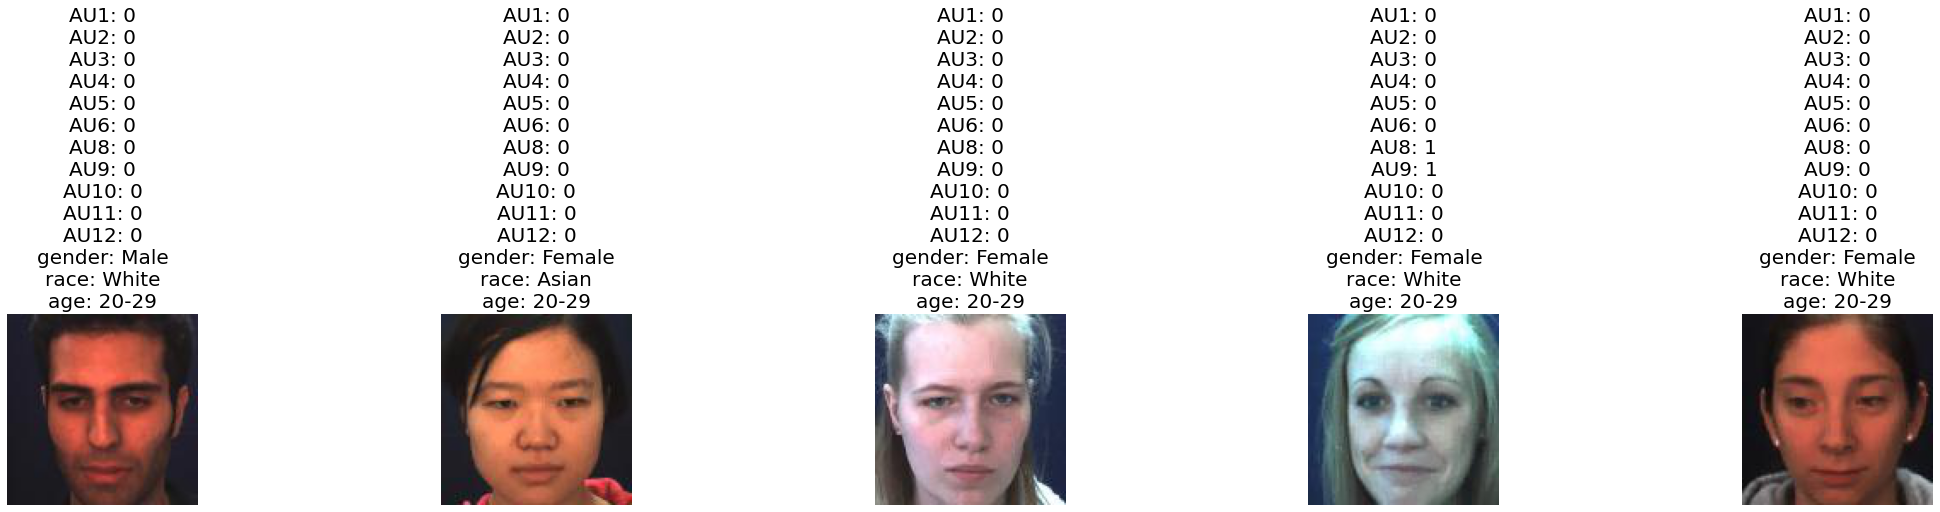

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i*30000
  image  =  mpimg.imread(df_train['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU3: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU8: {}\nAU9: {}\nAU10: {}\nAU11: {}\nAU12: {}\ngender: {}\nrace: {}\nage: {}'.format(
      df_train[1][index],df_train[2][index],df_train[3][index],df_train[4][index],df_train[5][index],df_train[6][index],
      df_train[8][index],df_train[9][index],df_train[10][index],df_train[11][index],df_train[12][index],df_train['gender'][index],df_train['race'][index],df_train['age'][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train['face_name_align'][122])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(112, 112, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 112*112 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 112 * 112 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='face_name_align',
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )


Found 206103 validated image filenames.
Found 48450 validated image filenames.


In [ ]:
df_train

,face_name_align,1,2,3,4,5,6,8,9,10,11,12,race,gender,age,video,frames
0,/content/disfa_aligned/disfa_aligned/RightVide...,0,0,0,0,0,0,0,0,0,0,0,White,Male,20-29,RightVideoSN006,4845
1,/content/disfa_aligned/disfa_aligned/RightVide...,0,0,0,0,0,0,0,0,0,0,0,White,Male,20-29,RightVideoSN006,4845
2,/content/disfa_aligned/disfa_aligned/RightVide...,0,0,0,0,0,0,0,0,0,0,0,White,Male,20-29,RightVideoSN006,4845
3,/content/disfa_aligned/disfa_aligned/RightVide...,0,0,0,0,0,0,0,0,0,0,0,White,Male,20-29,RightVideoSN006,4845
4,/content/disfa_aligned/disfa_aligned/RightVide...,0,0,0,0,0,0,0,0,0,0,0,White,Male,20-29,RightVideoSN006,4845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206098,/content/disfa_aligned/disfa_aligned/LeftVideo...,0,0,1,0,1,1,0,0,0,1,0,White,Male,20-29,LeftVideoSN032,4845
206099,/content/disfa_aligned/disfa_aligned/LeftVideo...,0,0,1,0,1,1,0,0,0,1,0,White,Male,20-29,LeftVideoSN032,4845
206100,/content/disfa_aligned/disfa_aligned/LeftVideo...,0,0,1,0,1,1,0,0,0,1,0,White,Male,20-29,LeftVideoSN032,4845
206101,/content/disfa_aligned/disfa_aligned/LeftVideo...,0,0,1,0,1,1,0,0,0,1,0,White,Male,20-29,LeftVideoSN032,4845


## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets")
set_names = ['train','test']
data = []
ratio_train = []
ratio_test = []
aus = []
for au in final_aus:  
  aus.append(au)    
  ratio_train.append(len(df_train[df_train[au]==1])/len(df_train))
  ratio_test.append(len(df_test[df_test[au]==1])/len(df_test))

table = zip(aus,ratio_train, ratio_test)
print(tabulate(table, headers=['AUs','train ratio','test ratio'], floatfmt=".4f"))




Actiavated AU ratio for all sets
  AUs    train ratio    test ratio
-----  -------------  ------------
    1         0.0619        0.0952
    2         0.0513        0.0804
    3         0.1855        0.2107
    4         0.0241        0.0075
    5         0.1456        0.1669
    6         0.0456        0.0906
    8         0.2450        0.2132
    9         0.1003        0.0967
   10         0.0290        0.0543
   11         0.3715        0.2997
   12         0.1893        0.2149


In [ ]:
def plot_samples(category_name,names,counter_train,counter_val):
  f, axs = plt.subplots(2,2,figsize=(16,5))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.bar(names,counter_train,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for train set".format(category_name),fontsize=15)

  plt.subplot(1, 2, 2) # row 1, col 2 index 1
  plt.bar(names,counter_val,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for validation set".format(category_name),fontsize=15)
  plt.show()


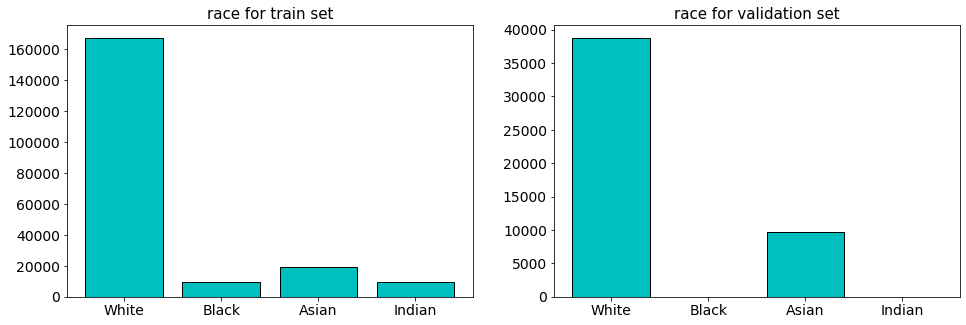

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train[df_train['race']==race_names[i]]))


race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test[df_test['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_test)


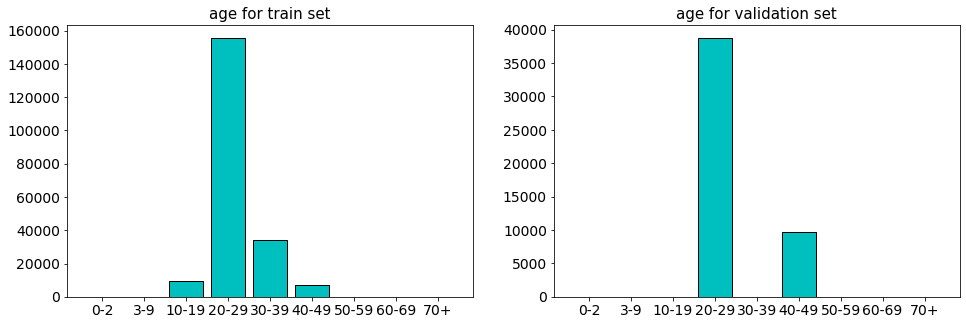

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train[df_train['age']==age_names[i]]))


age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test[df_test['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_test)


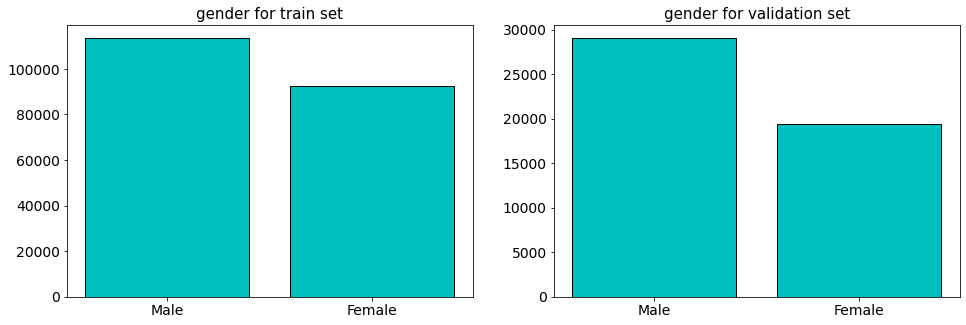

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train[df_train['gender']==gender_names[i]]))

gender_counter_test = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test[df_test['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_test)


## training

Multilabel binary classification problem <br>
 

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(112,112,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(11, activation='sigmoid')) 


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 11)                5643      
                                                                 
Total params: 24,642,443
Trainable params: 24,589,323
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.00001),
                     loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_before/Disfa-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
6441/6441 [==============================] - ETA: 0s - loss: 0.1088
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_before/Disfa-01.h5
6441/6441 [==============================] - 869s 132ms/step - loss: 0.1088 - val_loss: 0.4794
Epoch 2/10
6441/6441 [==============================] - ETA: 0s - loss: 0.0528
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_before/Disfa-02.h5
6441/6441 [==============================] - 826s 128ms/step - loss: 0.0528 - val_loss: 0.5482
Epoch 3/10
6441/6441 [==============================] - ETA: 0s - loss: 0.0393
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_before/Disfa-03.h5
6441/6441 [==============================] - 832s 129ms/step - loss: 0.0393 - val_loss: 0.5722
Epoch 4/10
6441/6441 [==============================] - ETA: 0s - loss: 0.0318
Epoch 4: saving model to /content/gdrive/MyDrive/train_net/ckp_mod

## evaluation & threshold
 

In [ ]:

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
  )


Found 48450 validated image filenames.


In [ ]:
#return list of predictions based on threshold
def threshold_predictions(predictions,thr):
  y_pred = [1 if i>=thr else 0 for i in predictions]
  return y_pred
  

In [ ]:
# calculates transformed predictions and returns mean of macro f1 score for all labels/prediction sets 
def macro_f1(labels,predictions,thr):
  predictions_thr =threshold_predictions(predictions,thr)
  f1 = f1_score(labels,predictions_thr,average='binary')
  return f1


In [ ]:
# dictionaries with keys   -- > AUs (11)
#                   values -- > labels/predictions of AU (len(test_images))

def labels_predictions_aus(labels,predictions):
  aus_labels = {k: [] for k in range(11)}
  aus_predictions =  {k: [] for k in range(11)}

  for l,p in zip(labels,predictions):
    for au in range(11):
      aus_labels[au].append(l[au])
      aus_predictions[au].append(p[au])
  return(aus_labels,aus_predictions)




In [ ]:
# calculates eachf1 & returns mean of all  f1 scores
def mean_macro_f1(aus_labels,aus_predictions,thr):
  f1_all = []
  for au in range(11):
    f1 = macro_f1(aus_labels[au],aus_predictions[au],thr)
    f1_all.append(f1)
  return (statistics.mean(f1_all))


In [ ]:
# return labels and predictions for each category
def labels_predictions__category(df_test,test_generator,labels,predictions,category_list,category_name):
  labels_cat = {key: [] for key in category_list}
  predictions_cat = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category

  for i,name in enumerate(test_generator.filenames):  
    category_filename = df_test.loc[df_test['face_name_align'] == name, category_name].item()
    for cat in category_list:
      if category_filename == cat:
          category_counter[cat].append(i)
          labels_cat[cat].append(labels[i])
          predictions_cat[cat].append(predictions[i])
        
    
  return labels_cat,predictions_cat,category_counter

In [ ]:
# calculates and shows results
def results_category(split,category_list,category_name,y_true,y_pred,thr,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for cat in category_list:
    aus_labels_cat,aus_predictions_cat = labels_predictions_aus(y_true[cat],y_pred[cat])
    data.append([cat,len(np.unique(indexes_to_videos(df_test,category_counter[cat]))),len(category_counter[cat]), mean_macro_f1(aus_labels_cat,aus_predictions_cat,thr)])
  print(tabulate(data, headers=[category_name,"#videos" ,"#frames","mean macro f1 score"]))
  print()



In [ ]:
#give indexes of category and out
def indexes_to_videos(df_test,counter):
  videos = df_test.video.unique()
  videos_counter = []
  for i in counter:
    video = df_test.iloc[i]['video']
    videos_counter.append(video)
  return videos_counter


In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_before'
for saved_model in (os.listdir(models_directory)):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model))
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


In [ ]:
for model_name in models_labels.keys():
  aus_labels,aus_predictions = labels_predictions_aus(models_labels[model_name],models_predictions[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels,aus_predictions,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = Disfa-09
 Threshold: 0.0 F1 score: 0.2349
 Threshold: 0.1 F1 score: 0.4291
 Threshold: 0.2 F1 score: 0.4182
 Threshold: 0.3 F1 score: 0.4087
 Threshold: 0.4 F1 score: 0.3994
 Threshold: 0.5 F1 score: 0.39
 Threshold: 0.6 F1 score: 0.3804
 Threshold: 0.7 F1 score: 0.3697
 Threshold: 0.8 F1 score: 0.3551
 Threshold: 0.9 F1 score: 0.3363
 Threshold: 1.0 F1 score: 0.0048


In [ ]:
best_model_name = 'Disfa-09'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)))
best_threshold = 0.1

In [ ]:
RACES =['White','Black','Asian','Indian']
y_true_race,y_pred_race,counter_race = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],RACES,'race')

GENDERS = ['Male','Female']
y_true_gender,y_pred_gender,counter_gender = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age,y_pred_age,counter_age = labels_predictions__category(df_test,test_generator,models_labels[best_model_name],models_predictions[best_model_name],AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
print("Disfa")
print("AUG")

print("BEFORE")
aus_labels_best, aus_predictions_best = labels_predictions_aus(models_labels[best_model_name],models_predictions[best_model_name])
data = [[mean_macro_f1(aus_labels_best,aus_predictions_best,best_threshold)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('before',RACES,'race',y_true_race,y_pred_race,best_threshold,counter_race)
results_category('before',GENDERS,'gender',y_true_gender,y_pred_gender,best_threshold,counter_gender)
results_category('before',AGES,'age',y_true_age,y_pred_age,best_threshold,counter_age)



Disfa
AUG
BEFORE
   macro f1 score
-----------------
         0.429078

race scores before split
race      #videos    #frames    mean macro f1 score
------  ---------  ---------  ---------------------
White           8      38760               0.489634
Black           0          0               0
Asian           2       9690               0.294071
Indian          0          0               0

gender scores before split
gender      #videos    #frames    mean macro f1 score
--------  ---------  ---------  ---------------------
Male              6      29070               0.390213
Female            4      19380               0.430005

age scores before split
age      #videos    #frames    mean macro f1 score
-----  ---------  ---------  ---------------------
0-2            0          0               0
3-9            0          0               0
10-19          0          0               0
20-29          8      38760               0.399812
30-39          0          0               0
40-49  

## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator.next()
prediction_show = best_model.predict(X)
for i in range(batch_size):
  print("truth:      {}\nprediction: {} ".format(y[i],np.array(threshold_predictions(prediction_show[i],best_threshold))))


Labels and Predictions for one batch
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 0 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0 0 0 0 0 0 1 0 0 0 0]
prediction: [0 0 0 0 0 0 0 1 0 1 1] 
truth:      [0

# after split

In [ ]:
df_all = pd.concat([df_train,df_test])
df_all= df_all.reset_index(drop=True)


In [ ]:
aggregation_functions = {'gender': 'first', 'race': 'first', 'age': 'first','video':'first','frames':'first'}
df_videos = df_all.groupby(df_all['video']).aggregate(aggregation_functions)

In [ ]:
GENDERS = ['Male','Female']
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

In [ ]:
#create bins directory
categories = []
for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      categories.append(tuple((gender,race,age)))
bins = dict.fromkeys(categories)

#fill bins 
for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      print("gender:",gender,"race:",race,"age:",age)
      bin = []
      for video in df_videos['video']:
        if ((df_videos.loc[df_videos.video ==	video,'gender'] == gender).bool() and 
                (df_videos.loc[df_videos.video ==	video,'race'] == race).bool() and 
                (df_videos.loc[df_videos.video ==	video,'age'] == age).bool()):
          bin.append(video)
      bins[(gender,race,age)] = bin
  

In [ ]:
# all frames of each bin
bin_frames_all = {}
# frames of each video
video_frames = {}
for bin,value in bins.items():
  bin_frames = []
  for video in value:
    frames = df_videos.loc[df_videos.video==video,'frames'].item()
    bin_frames.append(frames)
    video_frames[video] =frames
  bin_frames_all[bin] = sum(bin_frames)
  print("Bin: {} \nNumber of Videos: {} \nVideos: {}  \nFrames: {} \nFrames in bin: {}\n".format(bin,len(value),value,bin_frames,bin_frames_all[bin]))


In [ ]:
train_videos = ['LeftVideoSN028','LeftVideoSN027','LeftVideoSN001','LeftVideoSN002','LeftVideoSN006','LeftVideoSN016','LeftVideoSN017','LeftVideoSN024','LeftVideoSN004','LeftVideoSN003','LeftVideoSN007','LeftVideoSN010','LeftVideoSN018','LeftVideoSN021','LeftVideoSN005','RightVideoSN001','RightVideoSN002','RightVideoSN006','RightVideoSN016','RightVideoSN017','RightVideoSN024','RightVideoSN028','RightVideoSN027','RightVideoSN004','RightVideoSN003','RightVideoSN007','RightVideoSN010','RightVideoSN018','RightVideoSN021','RightVideoSN005']

test_videos = ['LeftVideoSN008','LeftVideoSN026','LeftVideoSN011','LeftVideoSN012','LeftVideoSN013','LeftVideoSN029','LeftVideoSN030','LeftVideoSN023','LeftVideoSN009','RightVideoSN026','RightVideoSN008','RightVideoSN013','RightVideoSN011','RightVideoSN012','RightVideoSN029','RightVideoSN030','RightVideoSN023','RightVideoSN009']

validation_videos = ['LeftVideoSN031','LeftVideoSN032','LeftVideoSN025','RightVideoSN031','RightVideoSN032','RightVideoSN025']

In [ ]:
len(train_videos)+len(validation_videos)+len(test_videos)

54

In [ ]:
len(train_videos),len(validation_videos),len(test_videos)

(30, 6, 18)

In [ ]:
df_train_fair = df_all[df_all['video'].isin(train_videos)].reset_index(drop=True)
df_validation_fair = df_all[df_all['video'].isin(validation_videos)].reset_index(drop=True)
df_test_fair = df_all[df_all['video'].isin(test_videos)].reset_index(drop=True)

## Class distribution

In [ ]:
print("Actiavated AU ratio for all sets")
set_names = ['train','validation','test']
data = []
ratio_train = []
ratio_val = []
ratio_test = []
aus = []
for au in final_aus:  
  aus.append(au)    
  ratio_train.append(len(df_train_fair[df_train_fair[au]==1])/len(df_train_fair))
  ratio_val.append(len(df_validation_fair[df_validation_fair[au]==1])/len(df_validation_fair))
  ratio_test.append(len(df_test_fair[df_test_fair[au]==1])/len(df_test_fair))


table = zip(aus,ratio_train, ratio_val, ratio_test)
print(tabulate(table, headers=['AUs','train ratio','validation ratio','test ratio'], floatfmt=".4f"))




Actiavated AU ratio for all sets
  AUs    train ratio    validation ratio    test ratio
-----  -------------  ------------------  ------------
    1         0.0668              0.0716        0.0695
    2         0.0530              0.0176        0.0767
    3         0.1822              0.1073        0.2324
    4         0.0289              0.0104        0.0113
    5         0.1713              0.0986        0.1311
    6         0.0532              0.0574        0.0545
    8         0.2393              0.3037        0.2159
    9         0.0860              0.0788        0.1294
   10         0.0370              0.0166        0.0344
   11         0.3223              0.6515        0.3161
   12         0.1876              0.4311        0.1236


In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

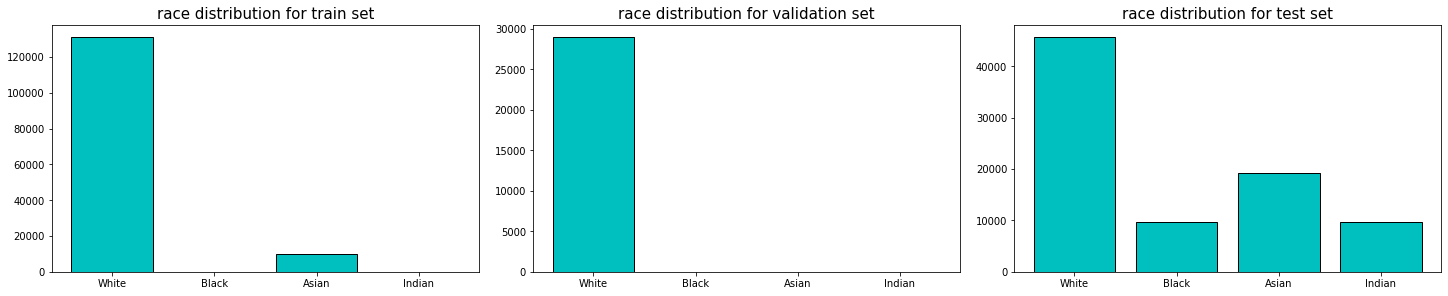

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


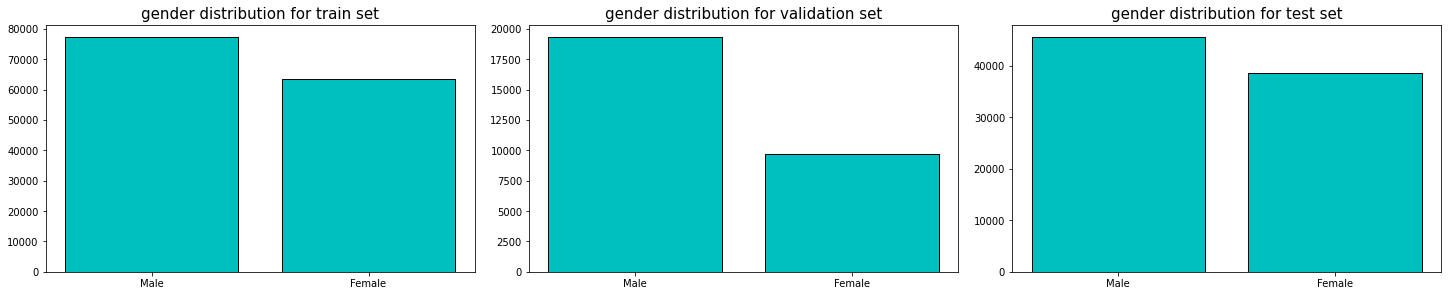

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_names[i]]))

gender_counter_test = []
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


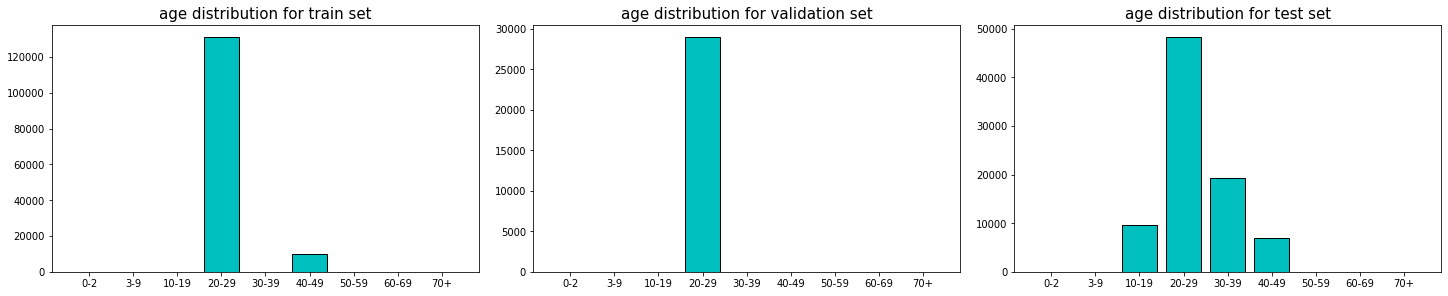

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


##Show data

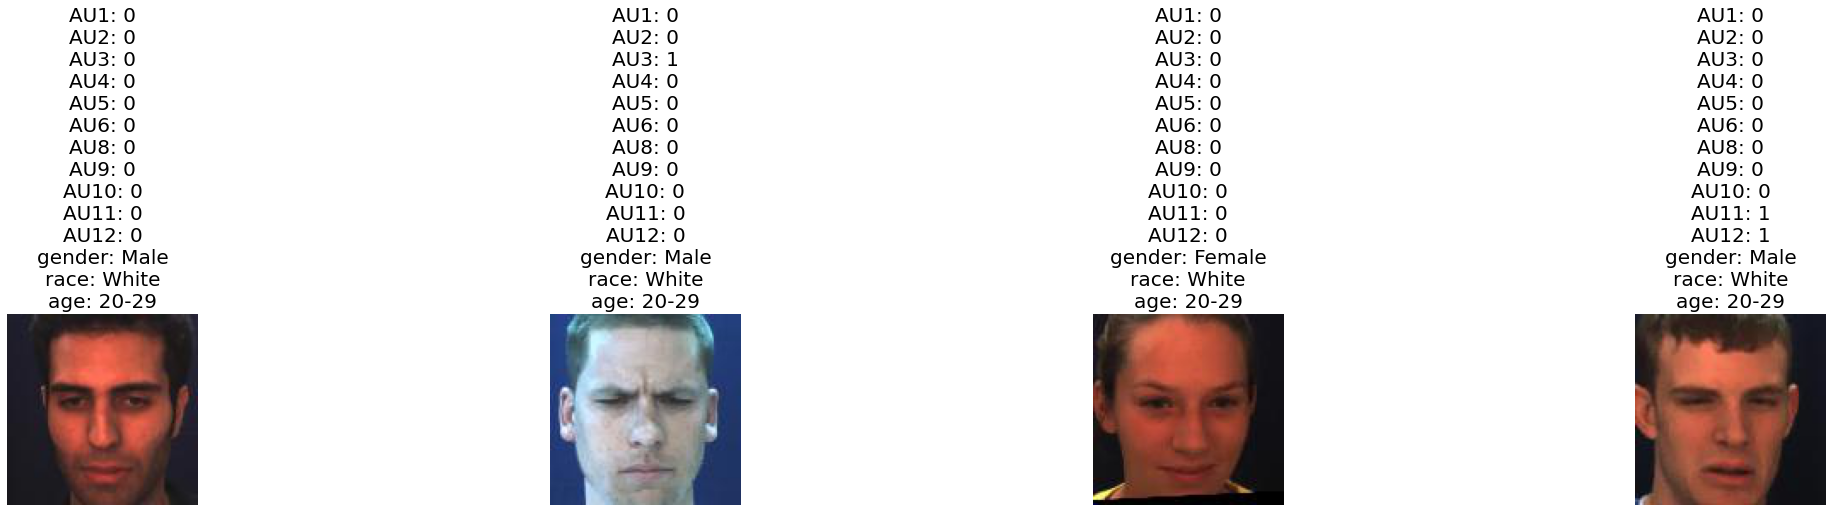

In [ ]:
num_images = 4
fig, axs = plt.subplots(figsize=(30, 7), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  index = i*30000
  image  =  mpimg.imread(df_train_fair['face_name_align'][index])
  axs[i].imshow(image)  
  axs[i].set_title('AU1: {}\nAU2: {}\nAU3: {}\nAU4: {}\nAU5: {}\nAU6: {}\nAU8: {}\nAU9: {}\nAU10: {}\nAU11: {}\nAU12: {}\ngender: {}\nrace: {}\nage: {}'.format(
      df_train_fair[1][index],df_train_fair[2][index],df_train_fair[3][index],df_train_fair[4][index],df_train_fair[5][index],df_train_fair[6][index],
      df_train_fair[8][index],df_train_fair[9][index],df_train_fair[10][index],df_train_fair[11][index],df_train_fair[12][index],df_train_fair['gender'][index],df_train_fair['race'][index],df_train_fair['age'][index]),fontsize = 20)
  axs[i].axis("off")

## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train_fair['face_name_align'][122])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(112, 112, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 112*112 και είναι έγχρωμες (τιμές απο 0-255). <br>
 Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 112* 112 * 3. 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    df_train_fair,
    x_col='face_name_align',
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw', #multilabel output numpy array of values in y_col column(s),
    batch_size=batch_size 
  )

validation_generator = test_datagen.flow_from_dataframe(
    df_validation_fair,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
  )


test_generator = test_datagen.flow_from_dataframe(
    df_test_fair,
    x_col="face_name_align",
    y_col=[1,2,3,4,5,6,8,9,10,11,12],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
  )


Found 141041 validated image filenames.
Found 29070 validated image filenames.
Found 84442 validated image filenames.


## training

Multilabel binary classification problem <br>
 

In [ ]:
#our model
resnet_model = Sequential()

#pretrained model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_tensor=None,
    input_shape=(112,112,3),
    pooling='avg' , #average
)
     
resnet_model.add(pretrained_model)

In [ ]:
# see layers of resnet 50
#pretrained_model.summary()

In [ ]:

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(11, activation='sigmoid')) 


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 11)                5643      
                                                                 
Total params: 24,642,443
Trainable params: 24,589,323
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.00001),#0.0001
                     loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_after/Disfa-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = resnet_model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
4408/4408 [==============================] - ETA: 0s - loss: 0.1225
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_after/Disfa-01.h5
4408/4408 [==============================] - 580s 130ms/step - loss: 0.1225 - val_loss: 0.3123
Epoch 2/10
4408/4408 [==============================] - ETA: 0s - loss: 0.0567
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_after/Disfa-02.h5
4408/4408 [==============================] - 561s 127ms/step - loss: 0.0567 - val_loss: 0.3175
Epoch 3/10
4408/4408 [==============================] - ETA: 0s - loss: 0.0416
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_after/Disfa-03.h5
4408/4408 [==============================] - 562s 127ms/step - loss: 0.0416 - val_loss: 0.3244
Epoch 4/10
4408/4408 [==============================] - ETA: 0s - loss: 0.0331
Epoch 4: saving model to /content/gdrive/MyDrive/train_net/ckp_models

## evaluation & threshold
 

In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/Disfa/Disfa_aug/Disfa_after'
for saved_model in (os.listdir(models_directory)):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model))
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


In [ ]:
for model_name in models_labels.keys():
  aus_labels,aus_predictions = labels_predictions_aus(models_labels[model_name],models_predictions[model_name])
  print("Model Name: =",model_name)
  for thr in np.arange(0,1.1,0.1):
    mean_f1 = mean_macro_f1(aus_labels,aus_predictions,thr)
    print(" Threshold: {} F1 score: {}".format(np.round(thr,2),np.round(mean_f1,4)))


Model Name: = Disfa-04
 Threshold: 0.0 F1 score: 0.2144
 Threshold: 0.1 F1 score: 0.3606
 Threshold: 0.2 F1 score: 0.3796
 Threshold: 0.3 F1 score: 0.3902
 Threshold: 0.4 F1 score: 0.3973
 Threshold: 0.5 F1 score: 0.3998
 Threshold: 0.6 F1 score: 0.3996
 Threshold: 0.7 F1 score: 0.3945
 Threshold: 0.8 F1 score: 0.3838
 Threshold: 0.9 F1 score: 0.3566
 Threshold: 1.0 F1 score: 0.0


In [ ]:
best_model_name = 'Disfa-04'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)))
best_threshold = 0.5

In [ ]:
RACES =['White','Black','Asian','Indian']
y_true_race,y_pred_race,race_counter = labels_predictions__category(df_test_fair,test_generator,models_labels[best_model_name],models_predictions[best_model_name],RACES,'race')

GENDERS = ['Male','Female']
y_true_gender,y_pred_gender,gender_counter = labels_predictions__category(df_test_fair,test_generator,models_labels[best_model_name],models_predictions[best_model_name],GENDERS,'gender')

AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
y_true_age,y_pred_age,age_counter = labels_predictions__category(df_test_fair,test_generator,models_labels[best_model_name],models_predictions[best_model_name],AGES,'age')



In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
# calculates and shows results
def results_category(split,category_list,category_name,y_true,y_pred,thr,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for cat in category_list:
    aus_labels_cat,aus_predictions_cat = labels_predictions_aus(y_true[cat],y_pred[cat])
    data.append([cat,len(np.unique(indexes_to_videos(df_test_fair,category_counter[cat]))),len(category_counter[cat]), mean_macro_f1(aus_labels_cat,aus_predictions_cat,thr)])
  print(tabulate(data, headers=[category_name,"#videos" ,"#frames","mean macro f1 score"]))
  print()



In [ ]:
print("Disfa")
print("AUG")
print("AFTER")
aus_labels_best, aus_predictions_best = labels_predictions_aus(models_labels[best_model_name],models_predictions[best_model_name])
data = [[mean_macro_f1(aus_labels_best,aus_predictions_best,best_threshold)]]
print(tabulate(data, headers=[" macro f1 score"]))
print()
results_category('after',RACES,'race',y_true_race,y_pred_race,best_threshold,race_counter)
results_category('after',GENDERS,'gender',y_true_gender,y_pred_gender,best_threshold,gender_counter)
results_category('after',AGES,'age',y_true_age,y_pred_age,best_threshold,age_counter)



Disfa
AUG
AFTER
   macro f1 score
-----------------
         0.399766

race scores after split
race      #videos    #frames    mean macro f1 score
------  ---------  ---------  ---------------------
White          10      45766               0.415441
Black           2       9690               0.267141
Asian           4      19296               0.349183
Indian          2       9690               0.505794

gender scores after split
gender      #videos    #frames    mean macro f1 score
--------  ---------  ---------  ---------------------
Male             10      45719               0.4177
Female            8      38723               0.379987

age scores after split
age      #videos    #frames    mean macro f1 score
-----  ---------  ---------  ---------------------
0-2            0          0               0
3-9            0          0               0
10-19          2       9690               0.385243
20-29         10      48413               0.353824
30-39          4      19333         

## Visualize predictions

In [ ]:
print("Labels and Predictions for one batch")
X,y = test_generator.next()
prediction_show = best_model.predict(X)
for i in range(batch_size):
  print("truth:      {}\nprediction: {} ".format(y[i],np.array(threshold_predictions(prediction_show[i],best_threshold))))


Labels and Predictions for one batch
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [1 0 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [0 0 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [0 0 0 0 0 0 0 1 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 1 0 0 1]
prediction: [1 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 1]
prediction: [0 0 1 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0 0 0 0 0 0 0 0 0 0 1]
prediction: [0 0 0 0 0 0 0 0 0 0 0] 
truth:      [0